# Boundary mapping

The purpose of this notebook is to mess around with all the different options available with boundary mapping

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('..', 'hypedsearch', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)


import database
import testing_utils
import operator
import collections

from preprocessing.merge_search import match_masses


#Assumptions:
max_peptide_length = 20
ppm_tolerance = 20

import matplotlib.pyplot as plt

In [2]:
datasets = testing_utils.define_data()

dataset = datasets[0]

input_spectra_path = dataset[0]
input_spectra, boundaries = testing_utils.preprocess_input_spectra(input_spectra_path, ppm_tolerance)

correct_sequences = testing_utils.generate_truth_set(datasets[0])

path = dataset[2]
db = database.build(path)

Loading spectra...
Done


In [4]:
# matched_masses_b, matched_masses_y, db = testing_utils.modified_match_masses(boundaries, db, max_peptide_length)
matched_masses_b, matched_masses_y, db = match_masses(boundaries, db, max_peptide_length)
print('Finished matching masses')

On protein 279/279 [100%]
Sorting the set of protein masses...
Sorting the set of protein masses done
Finished matching masses


In [7]:
print(len(matched_masses_b))
print(len(matched_masses_y))
print(matched_masses_b.keys())

13034
12961
dict_keys(['88.03592082595826-88.03944233322143', '102.05091456832886-102.05499668655395', '115.0467026210022-115.05130458114624', '116.03175982376099-116.0364011869812', '124.03727597976685-124.04223757003784', '126.05306665679932-126.05810888031006', '127.04557762893677-127.05065955368042', '129.06179554351806-129.06695811859132', '129.09754617126464-129.1027101763916', '130.04558629211425-130.0507882196045', '131.0799894317627-131.08523273620605', '133.05754997741698-133.06287238586427', '134.0410813317871-134.0464430822754', '135.0631098410034-135.06851247344972', '136.0709174432373-136.07636038879394', '136.0738928475952-136.07933591217042', '137.07602429382325-137.081507444458', '143.077689536438-143.0834127584839', '145.05564680267335-145.06144914459227', '148.05383207702636-148.0597543487549', '155.07703755737305-155.08324076293945', '156.07175338043214-156.07799637542723', '157.07568532775878-157.08196848083497', '157.09259172790527-157.09887555725098', '157.104417

In [14]:
with open('matched_masses.txt', 'w') as m:
    for entry in matched_masses_b.keys():
        m.write(str(matched_masses_b[entry]) + 'b' + '\n')
    for entry in matched_masses_y.keys():
        m.write(str(matched_masses_y[entry]) + 'b' + '\n')
print('Done')

Done


# Grabbing hits

In [4]:
spectrum_num = 0
correct_sequence = correct_sequences[spectrum_num]
print(correct_sequence)

input_spectrum = input_spectra[spectrum_num]

#Remember to add in abundance if it is helpful
b_hits, y_hits, b_set, y_set, misses = testing_utils.find_hits(boundaries, input_spectrum, spectrum_num, matched_masses_b, matched_masses_y)
correct_hits = testing_utils.append_correct_hits(correct_sequence, input_spectrum, ppm_tolerance)

DPQVEQLEL


# Writing hits

In [5]:
#Writing b and y hits
def write_hits(b_hits, y_hits):
    with open("b_hits.txt", 'w') as b:
        for x in b_hits:
            pep_id = x[0]
            w = x[1]
            prot_id = x[2][1]
            seq = x[2][2]
            loc = x[2][3]
            ion = x[2][4]
            charge = x[2][5]
            out = [pep_id, w, prot_id, seq, loc, ion, charge]
            b.write('\t'.join([str(i) for i in out]) + '\n')
    with open("y_hits.txt", 'w') as y_file:
        for y in y_hits:
            pep_id = y[0]
            w = y[1]
            prot_id = y[2][1]
            seq = y[2][2]
            loc = y[2][3]
            ion = y[2][4]
            charge = y[2][5]
            out = [pep_id, w, prot_id, seq, loc, ion, charge]
            y_file.write('\t'.join([str(i) for i in out]) + '\n')
    print('Done')

testing_utils.write_hits(b_hits, y_hits)

Done


# Clustering b hits

In [6]:
def create_clusters(ion):
    Hit = collections.namedtuple('Hit', 'pid start end seq mz')

    if ion == 'b':
        file_name = 'b_hits.txt'
        # file_name = sys.argv[1]

        hits = parse_hits(Hit, file_name)

        sorted_hits = sorted(hits, key=operator.attrgetter('pid', 'start', 'end'))

        last_pid = None
        last_start = None

        cluster = []

        with open('clusters.txt', 'w') as c:
            c.write('')

        if ion == 'b':
            for hit in sorted_hits:
                if last_pid == hit.pid and last_start == hit.start:
                    cluster.append(hit)
                else:
                    write_cluster(cluster)
                    cluster = [hit]
                last_pid = hit.pid
                last_start = hit.start
    
    else:
        file_name = 'y_hits.txt'
        # file_name = sys.argv[1]

        hits = parse_hits(Hit, file_name)

        sorted_hits = sorted(hits, key=operator.attrgetter('pid', 'start', 'end'))

        last_pid = None
        last_start = None

        cluster = []

        with open('clusters.txt', 'w') as c:
            c.write('')


        if ion == 'y':
            for hit in sorted_hits:
                if last_pid == hit.pid and last_end == hit.end:
                    cluster.append(hit)
                else:
                    write_cluster(cluster)
                    cluster = [hit]
                last_pid = hit.pid
                last_end = hit.end

def sort_clusters_by_post_prob(ion, boundaries, matched_masses_b, matched_masses_y):
    cluster = collections.namedtuple('cluster', 'post_prob prior score pid seq mz indices')
    if ion == 'b':
        b_cluster_array = []
        with open('clusters.txt', 'r') as c:
            for line in c:
                A = line.rstrip().split('\t')
                score = int(A[0])
                pid = int(A[1])
                seq = A[2]
                mz = float(A[3])
                indices = []
                [indices.append(A[x]) for x in range(4,len(A))]
                prior = set_prior(mz, ion, boundaries, matched_masses_b, matched_masses_y)
                post_prob = calc_post_prob(prior, indices)

                b_cluster_array.append(cluster(post_prob=post_prob, prior=prior, score=score, pid=pid, seq=seq, mz=mz, indices=indices) )

        b_sorted_clusters = sorted(b_cluster_array, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
        return b_sorted_clusters
    else:
        # y_hits
        y_cluster_array = []
        with open('clusters.txt', 'r') as c:
            for line in c:
                A = line.rstrip().split('\t')
                score = int(A[0])
                pid = int(A[1])
                seq = A[2]
                mz = float(A[3])
                indices = []
                [indices.append(A[x]) for x in range(4,len(A))]
                prior = set_prior(mz, ion, boundaries, matched_masses_b, matched_masses_y)
                post_prob = calc_post_prob(prior, indices)

                y_cluster_array.append(cluster(post_prob=post_prob, prior=prior, score=score, pid=pid, seq=seq, mz=mz, indices=indices) )

        y_sorted_clusters = sorted(y_cluster_array, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
        return y_sorted_clusters
def write_b_sorted_cluster(b_sorted_clusters):
    with open("b_sorted_clusters.txt", 'w') as b:
        [b.write(str(x) + '\n') for x in b_sorted_clusters]

In [7]:
ion = 'b'
testing_utils.create_clusters(ion)
b_sorted_clusters = testing_utils.sort_clusters_by_post_prob(ion, boundaries, matched_masses_b, matched_masses_y)

# Printing data

In [10]:
testing_utils.write_b_sorted_cluster(b_sorted_clusters)
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
for cluster in b_sorted_clusters:
    non_indices = str(cluster.score) + '\t' + str(cluster.post_prob) + '\t' + str(cluster.prior) + '\t' + str(cluster.pid) + '\t' + cluster.seq + '\t' + str(cluster.mz)
    print(non_indices) + '\t'.join([str(o) for o in cluster.indices])

2	0.28535353535353536	0.041666666666666664	67	REENAPKN	939.4456176757812


TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

# Clustering y_hits

In [14]:
ion = 'y'
testing_utils.create_clusters(ion)
y_sorted_clusters = testing_utils.sort_clusters_by_post_prob(ion, boundaries, matched_masses_b, matched_masses_y)

UnboundLocalError: local variable 'P_A' referenced before assignment

# Printing data

In [15]:
testing_utils.write_y_sorted_cluster(y_sorted_clusters)
for cluster in y_sorted_clusters:
    non_indices = str(cluster.score) + '\t' + str(cluster.post_prob) + '\t' + str(cluster.prior) + '\t' + str(cluster.pid) + '\t' + cluster.seq + '\t' + str(cluster.mz)
    print(non_indices) #+ '\t'+ '\t'.join([str(o) for o in cluster.indices]))
    
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)

NameError: name 'y_sorted_clusters' is not defined

# Plotting

In [11]:
print("Collecting data...")
score_array = []
posterior_array = []
bscore_array = []
for cluster in b_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='b')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
for cluster in y_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='y')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
print("Done")


Done


Text(0, 0.5, 'Posterior_array')

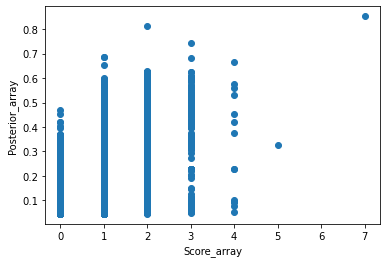

In [12]:
plt.scatter(score_array, posterior_array, s=None)
plt.xlabel('Score_array')
plt.ylabel('Posterior_array')

# Reading data

In [13]:
# First append all
print("Collecting data")
data_list = []
b_rank_list = []
y_rank_list = []
for rank, cluster in enumerate(b_sorted_clusters):
    target_tuple = (rank, cluster.seq)
    b_rank_list.append(target_tuple)
for rank, cluster in enumerate(y_sorted_clusters):
    target_tuple = (rank, cluster.seq)
    y_rank_list.append(target_tuple)
# with open("Data.txt", 'r') as data:
#     for line in data:
#         A = line.rstrip().split('\t')
#         score = A[0]
#         posterior = A[1]
#         bscore = A[2]
#         target_tuple = (score, posterior, bscore)
#         data_list.append(target_tuple)
print("Done")

Done


# Rank by count vs Rank by posterior probability

In [14]:
rank_by_count = []
rank_by_post_prob = []

b_sorted_clusters = sorted(b_cluster_array, key=operator.attrgetter('post_prob', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_cluster_array, key=operator.attrgetter('post_prob', 'pid', 'prior'), reverse = True)

score_b_sorted_clusters = sorted(b_cluster_array, key=operator.attrgetter('score', 'pid', 'prior'), reverse = True)
score_y_sorted_clusters = sorted(y_cluster_array, key=operator.attrgetter('score', 'pid', 'prior'), reverse = True)

for i, cluster in enumerate(b_sorted_clusters):
    rank_by_post_prob.append(i)
    for j, cluster2 in enumerate(score_b_sorted_clusters):
        if cluster2.seq == cluster.seq:
            rank_by_count.append(j)
            break
for i, cluster in enumerate(y_sorted_clusters):
    rank_by_post_prob.append(i)
    for j, cluster2 in enumerate(score_y_sorted_clusters):
        if cluster2.seq == cluster.seq:
            rank_by_count.append(j)
            break


Text(0, 0.5, 'Rank by posterior probability')

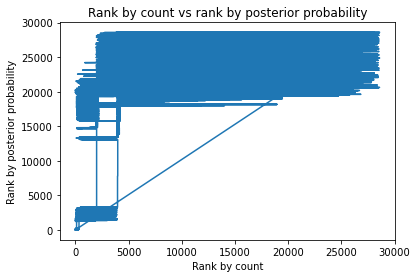

In [15]:
plt.plot(rank_by_count, rank_by_post_prob)
plt.title('Rank by count vs rank by posterior probability')
plt.xlabel('Rank by count')
plt.ylabel('Rank by posterior probability')

# To Filter data by parent prot

I want to be able to only view the b or y hits from a certain protein

In [16]:
# b_hits
target_pid = 274
b_target_clusters = []
for cluster in b_sorted_clusters:
    if cluster.pid == target_pid:
        b_target_clusters.append(cluster)

for cluster in b_target_clusters:
    non_indices = str(cluster.score) + '\t' + str(cluster.prob) + '\t' + str(cluster.pid) + '\t' + cluster.seq
    print(non_indices + '\t'+ '\t'.join([str(o) for o in cluster.indices]))


AttributeError: 'cluster' object has no attribute 'prob'

In [ ]:
# y_hits
target_pid = 274
y_target_clusters = []
for cluster in y_sorted_clusters:
    if cluster.pid == target_pid:
        y_target_clusters.append(cluster)

for cluster in y_target_clusters:
    non_indices = str(cluster.score) + '\t' + str(cluster.prob) + '\t' + str(cluster.pid) + '\t' + cluster.seq
    print(non_indices + '\t'+ '\t'.join([str(o) for o in cluster.indices]))

# See what non-hybrid solutions we can create

In [13]:
# b side starting. Ideally, we would probably pick the higher scoring side to start
filtered_b, filtered_y = testing_utils.get_top_X(b_sorted_clusters, y_sorted_clusters, 50)

# Calculating start and end indices for each interval
for b_cluster in filtered_b:
    interesting_combos = []
    b_index_set = set()
    for index in b_cluster.indices:
        index = index.replace('(', '')
        index = index.replace(')', '')
        A = index.rstrip().split(',')
        b_index_set.add(int(A[0]))
        b_index_set.add(int(A[1]))
    
    b_start_pos = min(b_index_set)
    b_end_pos = max(b_index_set)
    
    for y_cluster in filtered_y:
        y_index_set = set()
        for index in y_cluster.indices:
            index = index.replace('(', '')
            index = index.replace(')', '')
            A = index.rstrip().split(',')
            y_index_set.add(int(A[0]))
            y_index_set.add(int(A[1]))
            
        y_start_pos = min(y_index_set)
        y_end_pos = max(y_index_set)
        
        if (b_start_pos <= y_start_pos) and (b_end_pos == y_start_pos - 1):
            interesting_combos.append(b_cluster)
            interesting_combos.append(y_cluster)
    
    print(interesting_combos)

AttributeError: 'int' object has no attribute 'indices'